<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/big-data/step1_load_and_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project

## Big Portfolio Learner: Data Loading and Exploratory Analysis

### Team members: Steven Brooks & Chenlia Xu

In [1]:
import random
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [74]:
%%capture
## If boto3 not already installed uncomment the following:
!pip3 install boto3

In [2]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')

In [3]:
%%capture

stock_dir = "stock_data"
if not os.path.exists(in_dir):
  os.makedirs(in_dir)
!unzip /content/stock_data.zip -d /content/$in_dir
!rm -f $in_dir/.gitempty

# Setup Spark Session

In [69]:
%%capture

!apt install libkrb5-dev
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install imageio --user
!pip install folium --user

!apt update
!apt install gcc python-dev libkrb5-dev

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.getOrCreate()

In [5]:
%load_ext sparkmagic.magics

In [6]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

# Section 1: Exploratory Data Analysis

The schema of the stock price data is as below:

In [9]:
stock_data_files = os.listdir(stock_dir)
# head of a random file
pd.read_csv(os.path.join(stock_dir, stock_data_files[random.randrange(len(stock_data_files))])).head(5)

,symbol,timestamp,adjusted_close,volume
0,MUR,2021-12-17,25.10,4819803
1,MUR,2021-12-16,26.26,1672690
2,MUR,2021-12-15,26.57,1731394
3,MUR,2021-12-14,26.60,2400425
4,MUR,2021-12-13,27.27,1901657


We will load the data into the Spark context here.

In [10]:
stock_data_sdf = spark.read.load(
    'stock_data/*.csv', 
    format = 'csv', 
    header = 'true', 
    inferSchema = 'true', 
    sep = ','
)

stock_data_sdf.printSchema()

root
 |-- symbol: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: long (nullable = true)



## Step 1: Inspect the data

First look at the number of rows of data across within each year for each stock.  

In [16]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import year, month, date_format

# Adding "year" and "month" to the dataset
stock_data_sdf = stock_data_sdf.withColumn("timestamp_as_dt", to_timestamp(stock_data_sdf.timestamp, 'yyyy-MM-dd'))
stock_data_sdf = stock_data_sdf.withColumn("year", year('timestamp_as_dt'))
stock_data_sdf = stock_data_sdf.withColumn("month", month('timestamp_as_dt'))
stock_data_sdf = stock_data_sdf.withColumn("year_mon", date_format('timestamp_as_dt', 'yyyy-MM'))
stock_data_sdf.printSchema()

root
 |-- symbol: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- adjusted_close: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- timestamp_as_dt: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year_mon: string (nullable = true)



In [19]:
stock_data_sdf.show(5)

+------+----------+--------------+-------+-------------------+----+-----+--------+
|symbol| timestamp|adjusted_close| volume|    timestamp_as_dt|year|month|year_mon|
+------+----------+--------------+-------+-------------------+----+-----+--------+
|  ORCL|2019-12-31| 51.2961100336|7094518|2019-12-31 00:00:00|2019|   12| 2019-12|
|  ORCL|2019-12-30| 51.0250094143|5936134|2019-12-30 00:00:00|2019|   12| 2019-12|
|  ORCL|2019-12-27| 51.7608539523|7261963|2019-12-27 00:00:00|2019|   12| 2019-12|
|  ORCL|2019-12-26|  51.867357767|6702009|2019-12-26 00:00:00|2019|   12| 2019-12|
|  ORCL|2019-12-24| 51.7414896224|3331654|2019-12-24 00:00:00|2019|   12| 2019-12|
+------+----------+--------------+-------+-------------------+----+-----+--------+
only showing top 5 rows



#### We'll just look at the data from the years we are interested in: 2002 to 2019, inclusive.

In [17]:
stock_data_sdf = stock_data_sdf.filter("year >= 2002 AND year <= 2019")

Here we calculate how many rows of data per year there are for each stock. Each row corresponds to a trading day.

We'll only take stocks that have data in each year between 2002 and 2019, inclusive.

In [20]:
count_by_symbol_year_sdf = stock_data_sdf.groupBy(["symbol", "year"]).count()
count_years_by_symbol_sdf = count_by_symbol_year_sdf.groupBy(["symbol"]).count()

stocks_with_all_analysis_yrs_sdf = count_years_by_symbol_sdf.filter("count == 18") #18 years of data from 2002 and 2019

print("There are", stocks_with_all_analysis_yrs_sdf.count(), "stocks with data in each year from 2002 and 2019")

There are 579 stocks with data in each year from 2002 and 2019


Now we move into SQL to limit the dataset to just these stocks that have full data in our analysis time range.

But first, lets visualize the number of rows per year for this set of stocks.

In [21]:
stock_data_sdf.createOrReplaceTempView("stock_data")
count_by_symbol_year_sdf.createOrReplaceTempView("count_by_symbol_year")
stocks_with_all_analysis_yrs_sdf.createOrReplaceTempView("stocks_with_all_analysis_yrs")

count_by_symbol_year_filtered = spark.sql(
    """
    SELECT L.symbol, R.year, R.count
    FROM stocks_with_all_analysis_yrs L JOIN count_by_symbol_year R
    ON L.symbol = R.symbol
    """
).toPandas()

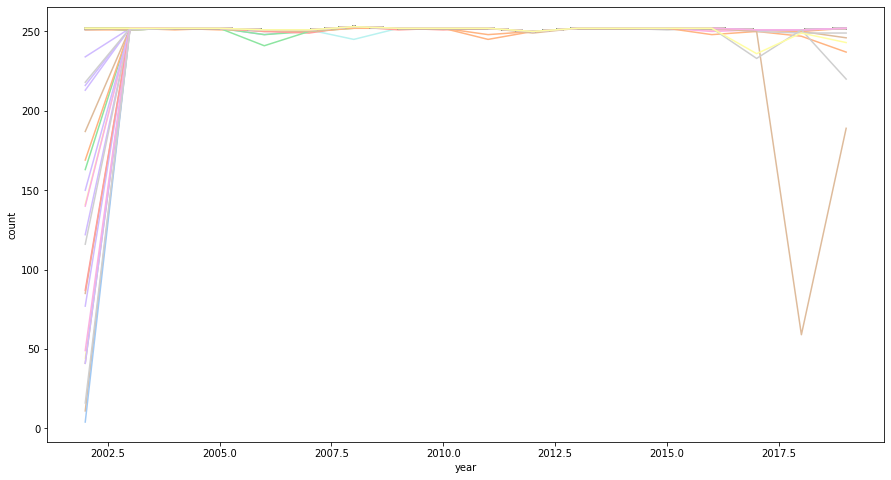

In [22]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

_ = sns.lineplot(
    x = "year", y = "count", 
    hue = "symbol", palette = "pastel", 
    legend = False, data = count_by_symbol_year_filtered
)

Now we will filter out just these stocks of interest from the main dataset.

In [23]:
spark.sql(
    """
    SELECT *
    FROM stock_data
    WHERE symbol IN (SELECT symbol FROM stocks_with_all_analysis_yrs)
    """
).createOrReplaceTempView("stock_data_2002_2019")

And confirm the number here matches the above.

In [24]:
spark.sql(
    """
    SELECT count(distinct(symbol))
    FROM stock_data_2002_2019
    """
).show()

+----------------------+
|count(DISTINCT symbol)|
+----------------------+
|                   579|
+----------------------+



Finally, clean out some stocks that have outlier prices, like "DCTH"

In [25]:
import pyspark.sql.functions as F

stock_data_2002_2019_sdf = spark.sql("SELECT * FROM stock_data_2002_2019")

highest_closers_sdf = stock_data_2002_2019_sdf.groupBy('symbol').agg(F.max('adjusted_close').alias('max_close')).sort("max_close", ascending = False).limit(10)

highest_closers_sdf.show()

+------+-------------+
|symbol|    max_close|
+------+-------------+
|  DCTH|  5.074048E11|
| BRK-A|     340380.0|
|  AIKI|171404.255319|
|  MBOT|      11268.0|
|  NEON|      10612.5|
|  FLUX|      10000.0|
|  CLBS|       6800.0|
|   NVR|      3892.89|
|  BKNG|      2206.09|
|  AMZN|      2039.51|
+------+-------------+



In [26]:
stocks_to_remove = ['DCTH', 'BRK-A', 'AIKI']

stock_data_2002_2019_sdf = stock_data_2002_2019_sdf.filter(stock_data_2002_2019_sdf.symbol.isin(stocks_to_remove) == False)

from pyspark.sql.functions import countDistinct

stock_data_2002_2019_sdf.select(countDistinct("symbol")).show()

+----------------------+
|count(DISTINCT symbol)|
+----------------------+
|                   576|
+----------------------+



## Step 2: Visualize the time series data of adjusted closing price per day over this span.

We'll take a small sample to visualize just to make it faster.


In [53]:
subset = list(stocks_with_all_analysis_yrs_sdf.sample(0.1, 42).toPandas().symbol)

subset_for_viz = stock_data_2002_2019_sdf.filter(stock_data_2002_2019_sdf.symbol.isin(subset)).toPandas()

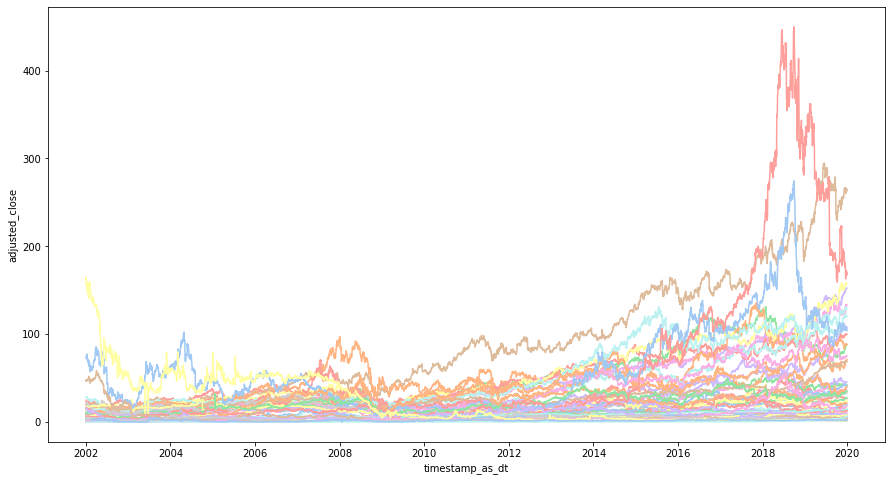

In [54]:
_ = sns.lineplot(
    x = "timestamp_as_dt", y = "adjusted_close", 
    hue = "symbol", palette = "pastel", legend = False, 
    data = subset_for_viz
)

This plot clearly shows us that stock data over time is non-stationary: the mean changes with time, and the variance of the series looks time dependent as well.

#### Next, we will check if there is any seasonality trends by month

[(0.0, 100.0)]

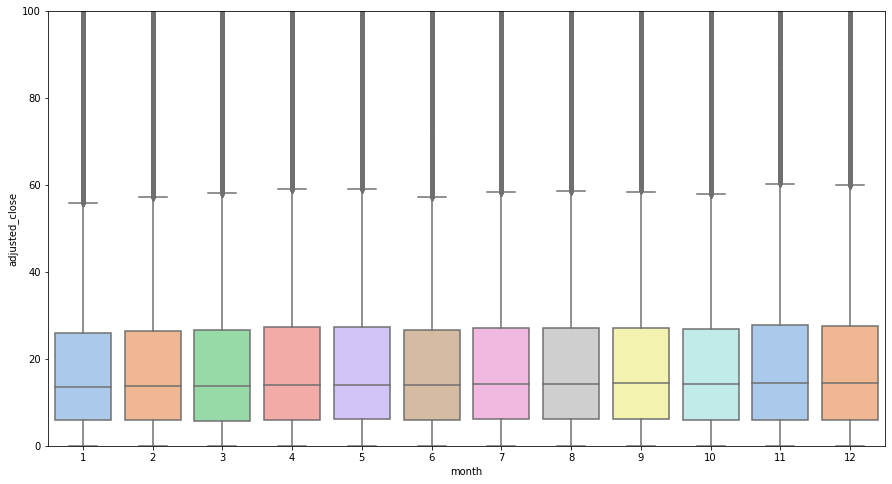

In [58]:
ax = sns.boxplot(
    x = 'month', y = 'adjusted_close',
    palette = 'pastel',
    data = subset_for_viz
)

ax.set(ylim=(0, 100))

Looks like there are no seasonal trends.

# Section 2: Assess what kind of time series process our data is.

Here we will look at the daily adjusted close price data and time.

We will use differencing and a log transform to take out the trends and stabilize the variance in the data (i.e., make it stationary).

In [59]:
subset_for_viz = subset_for_viz.sort_values(by = ['symbol', 'timestamp_as_dt'])

subset_for_viz['adjusted_close_log'] = np.log(subset_for_viz['adjusted_close'])

subset_for_viz['adjusted_close_log_diff'] = subset_for_viz.groupby('symbol')['adjusted_close_log'].diff()

subset_for_viz.reset_index(inplace = True)
subset_for_viz.dropna(inplace = True)

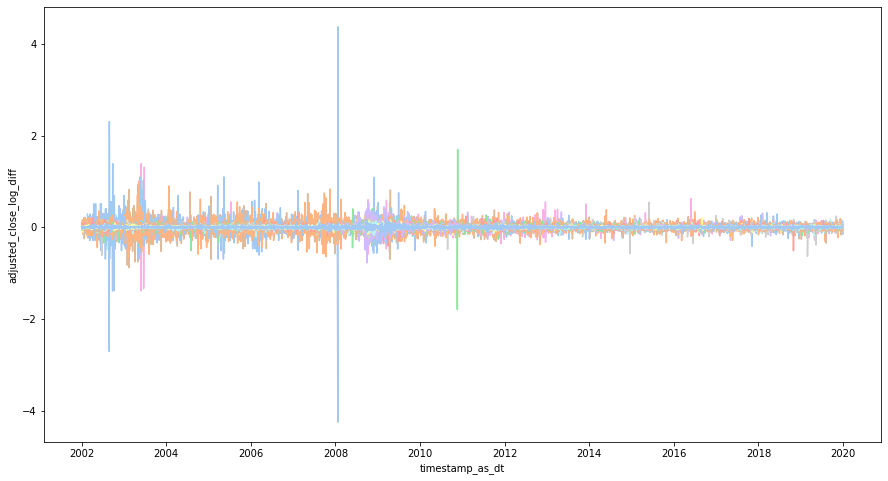

In [60]:
_ = sns.lineplot(
    x = "timestamp_as_dt", y = "adjusted_close_log_diff", 
    hue = "symbol", palette = "pastel", legend = False, 
    data = subset_for_viz
)

We will now look at the Autocorrelation plots to see which parameters we need to use in our time series model.

Stock data is typically an Autoregressive time series with lag of 1, but we will use the ACF and PACF plots to check what the optimal lag parameter is.

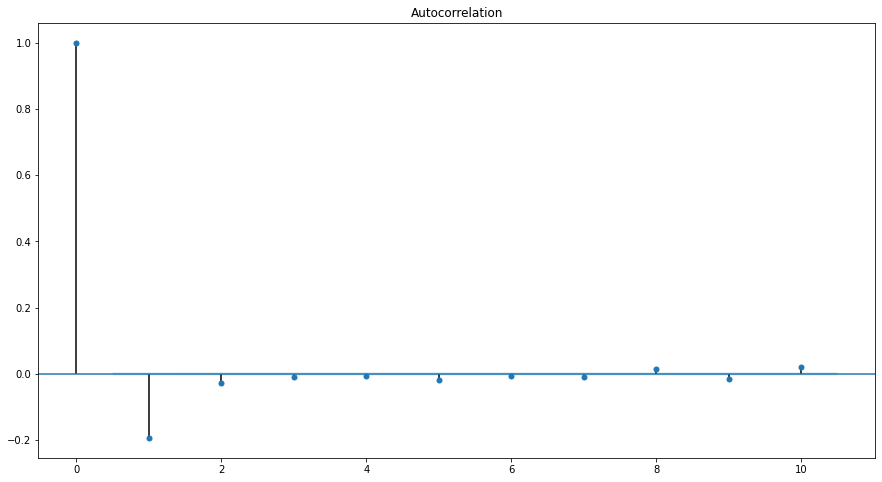

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(subset_for_viz['adjusted_close_log_diff'], lags = 10)

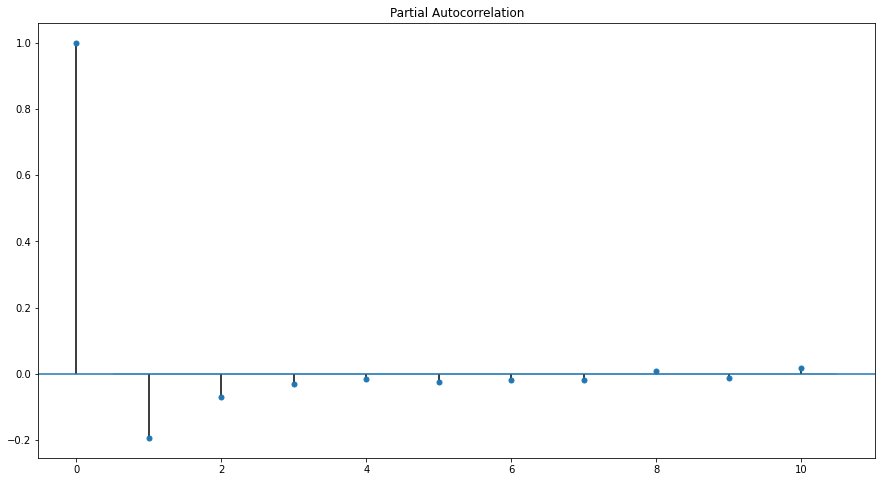

In [67]:
_ = plot_pacf(subset_for_viz['adjusted_close_log_diff'], lags = 10)

Looks like it is indeed an AR(1) process.

Lets save our analysis dataset so far to pick up for modeling in the next notebook.

In [73]:
stock_data_2002_2019_sdf.coalesce(1).write.csv('stock_data_2002_2019.csv')

Continued in the next notebook!